In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
ocean_discord = pd.read_csv('data/oceandiscord.csv')
ocean_discord['Date'] = pd.to_datetime(ocean_discord['Date'].astype(str).str[:10]) #just days
# Group by 'Date' and aggregate counts of messages, attachments, and reactions
daily_activity = ocean_discord.groupby('Date').agg({
    'Content': 'count',       # Count of messages
}).reset_index()

daily_activity = daily_activity[['Date', 'Content']]

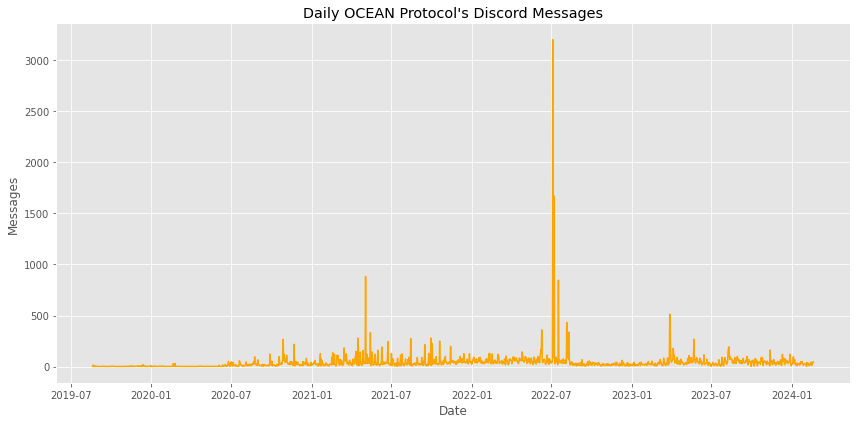

In [3]:
df1 = daily_activity.set_index('Date').Content

plt.figure(figsize=(12,6))
plt.plot(df1, linewidth=1.5, color='orange')
plt.title("Daily OCEAN Protocol's Discord Messages")
plt.xlabel('Date')
plt.ylabel('Messages')
plt.tight_layout()
plt.show()

In [4]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('The timeseries is Stationary' if p_value < 0.05 else 'The timeseries is Non-Stationary')

check_stationarity(df1)

ADF Statistic: -6.294733356040649
p-value: 3.528542904977502e-08
The timeseries is Stationary


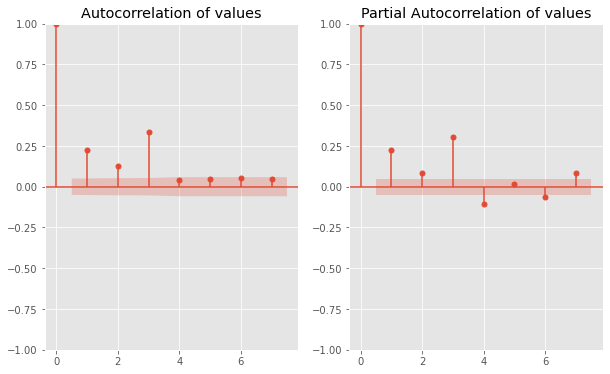

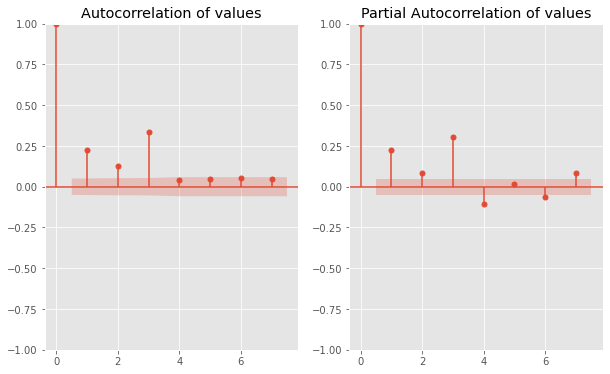

In [4]:
# Plot the ACF and PACF

l = 7
_, ax = plt.subplots(1,2, figsize = (10,6))
plot_acf( df1, lags=l, ax = ax[0], title = 'Autocorrelation of values')
plot_pacf(df1, lags=l, ax = ax[1], title = 'Partial Autocorrelation of values')

In [5]:
import itertools
ps = range(0, 3) # by partial autocorr
ds = range(0, 0)
qs = range(0, 3) # by autocorr


s = 365 # Assuming we have daily seasonality 
parameters = itertools.product(ps, ds, qs, [0], [0], [0], [s])
parameters_list = list(parameters)
print(len(parameters_list))

9


In [6]:
def ts_metrics(y_true, y_pred):
    return {
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        # 'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        # 'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
        # 'nmse':  np.sum((y_true - y_pred)**2) / np.sum((y_true)**2),
    }

In [7]:
%%time
x = df1
list_param = []
list_res   = []
list_time  = []
list_pred  = []
import gc
import time
n = len(x)
n1 = 365

for p in parameters_list:
    t1 = time.time()
    list_res1 = list()
    list_pred1 = list()
    # train-valid split
    for k in range(1):
        train, valid = x[:-n1], x[-n1:]
        
        # train
        try:
            model_arima = SARIMAX(train, order=(p[0],p[1],p[2]), seasonal_order=(p[3],p[4],p[5],p[6]))
            model_arima = model_arima.fit(disp=-1)
        except Exception as e:
            print(p, e)
            break
            
        # predict
        pred = model_arima.predict(start = 0, end = n - 1)
        pred = pred[-n1:]
        list_pred1 += list(pred)
        
        # evaluate
        res = ts_metrics(valid, pred)
        list_res1.append(res)
        
        del model_arima
        gc.collect()
        
        # break
        
    # collect
    if len(list_pred1) > 0:
        list_pred.append(list_pred1)
        list_res.append(pd.DataFrame(list_res1).mean())
        list_time.append({'time':time.time() - t1})
        list_param.append(p)

CPU times: total: 1.69 s
Wall time: 3.99 s


In [9]:
# results
df_out = pd.concat([
    pd.DataFrame(list_param, columns = ['p','d','q','P','D','Q','S']),
    pd.DataFrame(list_res),
    pd.DataFrame(list_time),
], axis = 1).sort_values('mae')

df_out.drop(['P', 'D', 'Q', 'S', 'time'], axis=1,inplace=True)
df_out.reset_index(inplace = True)
del df_out['index']
df_out[:10]

,p,d,q,mae,mse
0,2,0,1,39.460695,3359.418785
1,1,0,2,39.703667,3380.135637
2,2,0,2,41.879699,3572.314107
3,1,0,1,45.152989,3904.165862
4,2,0,0,46.019927,3975.830175
5,1,0,0,46.042332,3976.369267
6,0,0,2,46.050838,3976.553806
7,0,0,1,46.051151,3976.562111
8,0,0,0,46.063014,3976.819178


In [29]:
model = SARIMAX(x, order=(2, 0, 1), seasonal_order=(0, 0, 0, 365))
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Content   No. Observations:                 1537
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -9295.884
Date:                Sun, 10 Mar 2024   AIC                          18599.769
Time:                        20:28:22   BIC                          18621.119
Sample:                             0   HQIC                         18607.713
                               - 1537                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1377      0.011    102.248      0.000       1.116       1.159
ar.L2         -0.1431      0.010    -14.437      0.000      -0.163      -0.124
ma.L1         -0.9508      0.007   -140.288      0.000      -0.964      -0.938
sigma2      1.048e+04     38.355    273.324      0.000    1.04e+04    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):          24006420.15
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            21.49
Prob(H) (two-sided):                  0.00   Kurtosis:                       613.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

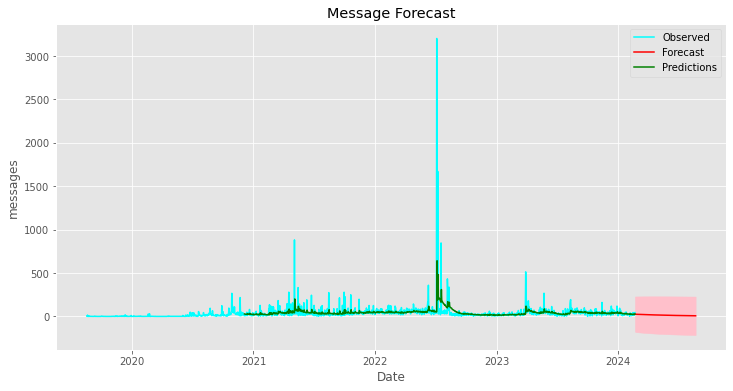

In [42]:

forecast_periods = 183 # Forecast the next 365 days
forecast = fitted_model.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
predictions = fitted_model.predict(start=365, steps=365)
 
start_date = ocean_discord['Date'].max()

forecast_mean.index =  pd.date_range(start=start_date, periods=forecast_periods, freq='D')
forecast_ci.index =  pd.date_range(start=start_date, periods=forecast_periods, freq='D')
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df1, label='Observed', color='cyan')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.plot(predictions, label='Predictions', color='green')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Message Forecast")
plt.xlabel("Date")
plt.ylabel("messages")
plt.legend()
plt.show()